In [1]:
%load_ext autoreload
%autoreload 2

## 10.2 Regression with ARIMA errors
We want to fit a regression model with ARIMA errors when exogenous regressors are included win the formula. Since we are working in Python instead of R, we need to use different packages to reproduce the examples in the book.
### Example: US Personal Consumption and Income

In [2]:
import sys
sys.path.append('../')
from utils import *

In [3]:
us_change = (
    pd.read_csv('../data/fpp3/us_change.csv')
    .assign(date=lambda df: pd.to_datetime(df['Quarter'].str.replace(' ', '')))
    .set_index('date')
    .pipe(set_freq)
)

In [20]:
us_consumption = (
    pd.DataFrame(us_change.Consumption)
    .rename(columns={"Consumption": "value"})
    .assign(var="Consumption")
)
us_income = (
    pd.DataFrame(us_change.Income)
    .rename(columns={"Income": "value"})
    .assign(var="Income")
)

Percentage changes in quarterly personal consumption expenditure and personal disposable income for the USA, 1970 Q1 to 2019 Q2:

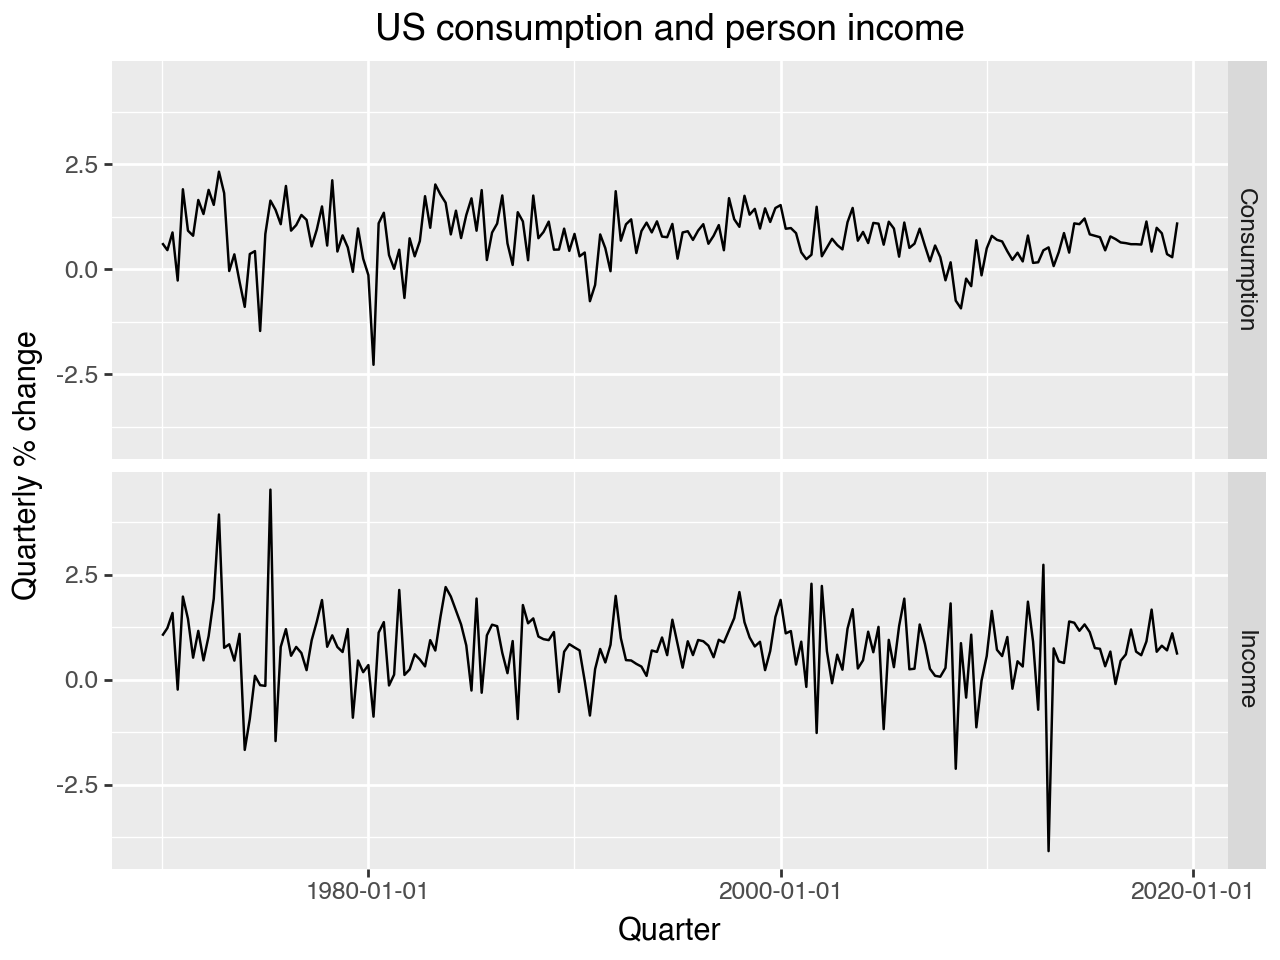

In [21]:
(
    ggplot(pd.concat([us_consumption, us_income]).reset_index())
    + aes(x="date", y="value")
    + geom_line()
    + facet_grid(rows="var")
    + labs(
        title="US consumption and person income", x="Quarter", y="Quarterly % change"
    )
)

Since `statsmodels` does not have the `ARIMA()` function that automatically fits the best model, we use the `(p, d, q) = (1, 0, 2)` values in the book to find the optimal parameters using `SARIMAX`. We can run this later using `statsforecast` to see whether it will identify the same set of parameters.

In [4]:
df = us_change.copy()

In [39]:
fit = sm.tsa.statespace.SARIMAX(df.Consumption, df.Income, order=(1, 0, 2), trend='c').fit(disp=0)

In [40]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  198
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -163.036
Date:                Tue, 26 Nov 2024   AIC                            338.072
Time:                        11:12:02   BIC                            357.802
Sample:                    01-01-1970   HQIC                           346.058
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1742      0.062      2.788      0.005       0.052       0.297
Income         0.1976      0.034      5.855      0.000       0.131       0.264
ar.L1          0.7071      0.106      6.659      0.000       0.499       0.915
ma.L1         -0.6173      0.113     -5.470      0.000      -0.839      -0.396
ma.L2          0.2066      0.065      3.174      0.002       0.079       0.334
sigma2         0.3035      0.022     13.525      0.000       0.260       0.347
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                45.83
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The data are clearly already stationary (as we are considering percentage changes rather than raw expenditure and income), so there is no need for any differencing. The fitted model is
$$
\begin{align*}
\eta_t & = 0.707\eta_{t-1} + \varepsilon_t - 0.617\varepsilon_{t-1} + 0.207\varepsilon_{t-2} \\
\varepsilon & \sim \mathrm{NID}(0, 0.303) \\
y_t & = 0.174 + 0.198x_t + \eta_t.
\end{align*}
$$
For some reason we get the same parameters for the ARIMA model as in the book, but not the same intercept of $y_t$. 

We want to test that the residuals have no autocorrelation using the Ljung-Box test: here we need to set the `model_df` parameter, which is the value we need to adjust the degree of freedom of the test by. For an ARIMA model, this is usually $p+q$, which in this case is 3. The results suggest that the residual indeed has no significant autocorrelation.

In [ ]:
sm.stats.acorr_ljungbox(fit.resid, lags=[8], model_df=3, boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
8,5.22128,0.389476,4.99043,0.417049


In [20]:
results = pd.DataFrame(fit.resid)
results['orig'] = fit.model.endog.flatten()
results['fitted'] = fit.fittedvalues
results.columns = ['residual', 'orig', 'fitted']

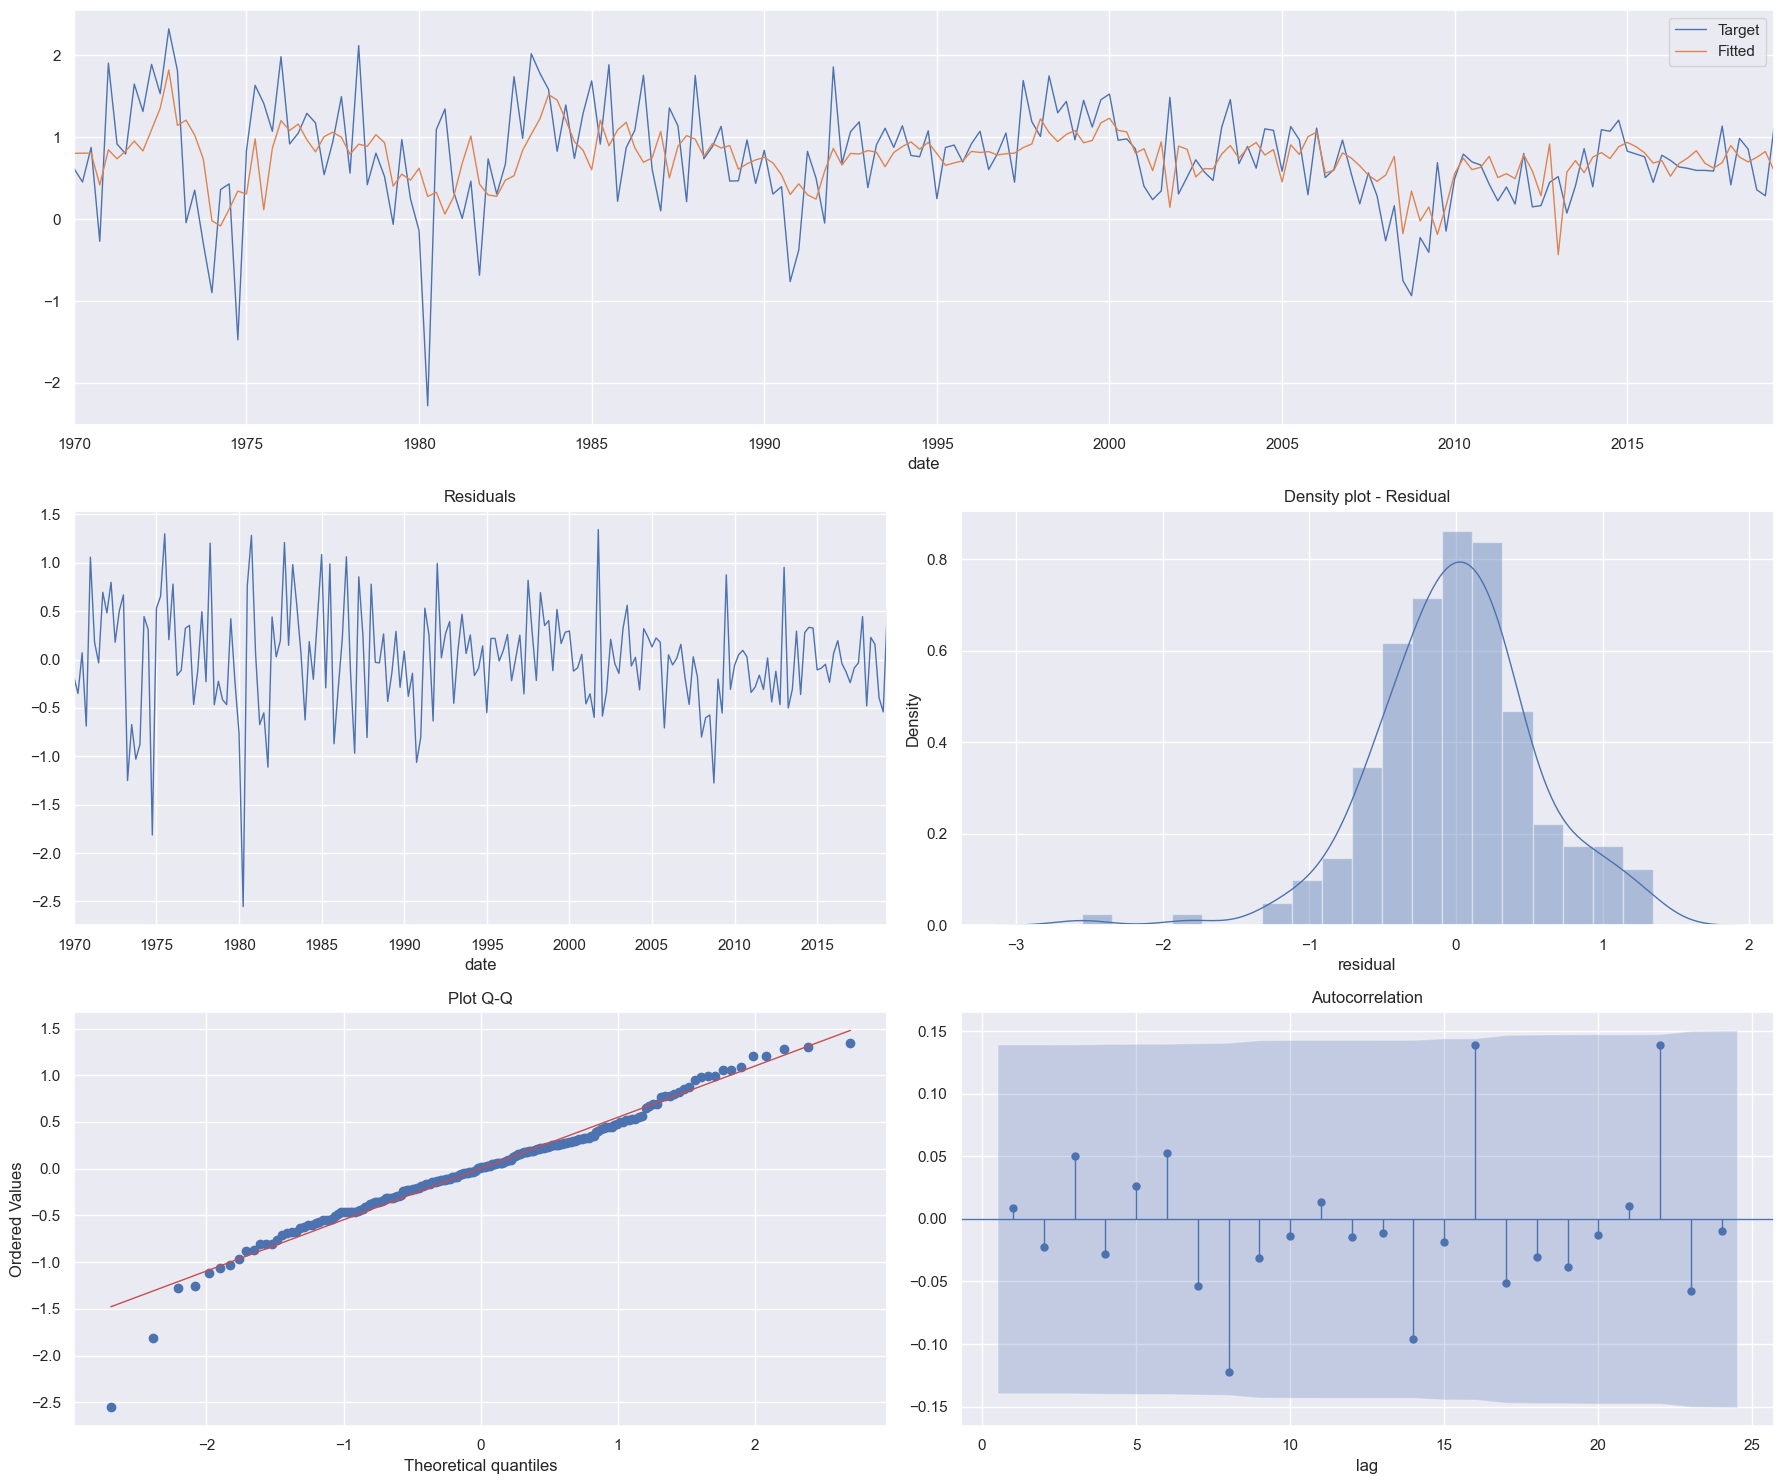

In [36]:
plot_fitted_residuals(fit)

### Forecasting
For details see next section. We will calculate forecasts for the next eight quarters assuming that the future percentage changes in personal disposable income will be equal to the mean percentage change from the last forty years.

In [44]:
exog = np.repeat(df['Income'].mean(), 8)
forecast = fit.get_forecast(len(exog), exog=exog)

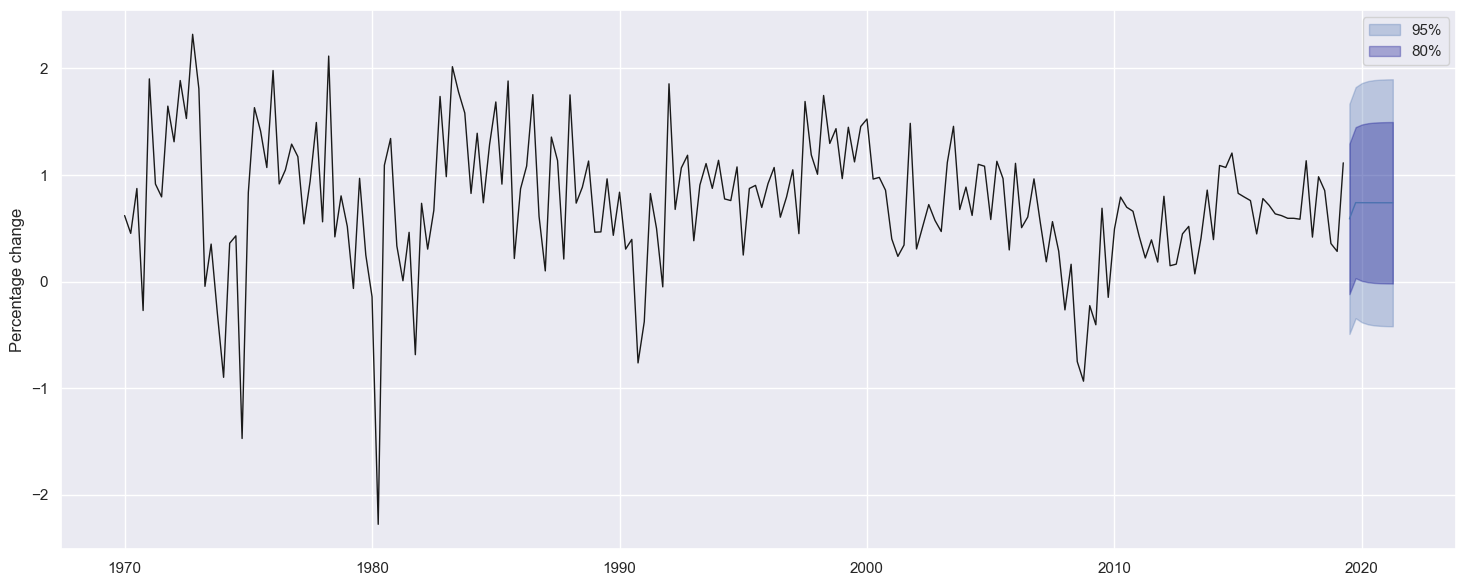

In [53]:
fig, ax = plt.subplots()
ax.plot(df['Consumption'], 'k')

ax.plot(forecast.predicted_mean)
ci = ciclean(forecast.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0', label='95%')
ci = ciclean(forecast.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='darkblue', label='80%')
ax.set(ylabel='Percentage change')
ax.legend();